# Customer Demographic Clustering

### Import modules

In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

### Data cleanup

In [108]:
df = pd.read_csv('twm_customer.csv', sep=';')
df.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


In [109]:
# df = df[['income', 'age', 'years_with_bank', 'nbr_children']]
# df

In [110]:
one_enc = OneHotEncoder(handle_unknown='ignore')

In [111]:
# encoding from https://medium.com/wicds/label-and-one-hot-encoding-61525a32b99c
# create dummy variable for gender then rename
enc_df = pd.DataFrame(one_enc.fit_transform(df[['gender']]).toarray())
enc_df.rename(columns={
    0 : 'female',
    1 : 'male',
}, inplace=True)
# create dummy variable for marital status then rename
# ASSUMPTION: used US census marital status categories
# marital_status = 3 contained 63% women compared to 57% men in marital_status = 4 therefore assumed it meant widowed
enc_df2 = pd.DataFrame(one_enc.fit_transform(df[['marital_status']]).toarray())
enc_df2.rename(columns={
    0 : 'single',
    1 : 'married',
    2 : 'widowed',
    3 : 'divorced'
}, inplace=True)
# join to original dataframe
df = df.join([enc_df, enc_df2])
df.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,...,street_name,postal_code,city_name,state_code,female,male,single,married,widowed,divorced
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,...,Second ...,89194,Las Vegas,NV,0.0,1.0,0.0,1.0,0.0,0.0
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,...,Daffodil ...,90159,Los Angeles,CA,0.0,1.0,0.0,1.0,0.0,0.0
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,...,Figueroa ...,90024,Los Angeles,CA,1.0,0.0,1.0,0.0,0.0,0.0
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,...,Humble ...,90172,Los Angeles,CA,1.0,0.0,1.0,0.0,0.0,0.0
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,...,C ...,10138,New York City,NY,1.0,0.0,0.0,0.0,0.0,1.0


In [112]:
# drop nondescriptive columns that won't be used for PCA
df.drop(columns=[
    'first_name', 'last_name', 'street_name', 'city_name',
    'cust_id', 'name_prefix', 'street_nbr', 'gender',
    'state_code', 'marital_status', 'postal_code'
], inplace=True)
df.head()

,income,age,years_with_bank,nbr_children,female,male,single,married,widowed,divorced
0,26150,46,5,1,0.0,1.0,0.0,1.0,0.0,0.0
1,6605,71,1,0,0.0,1.0,0.0,1.0,0.0,0.0
2,18548,38,8,0,1.0,0.0,1.0,0.0,0.0,0.0
3,47668,54,3,0,1.0,0.0,1.0,0.0,0.0,0.0
4,44554,59,9,2,1.0,0.0,0.0,0.0,0.0,1.0


In [113]:
df.isnull().describe()

,income,age,years_with_bank,nbr_children,female,male,single,married,widowed,divorced
count,747,747,747,747,747,747,747,747,747,747
unique,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False
freq,747,747,747,747,747,747,747,747,747,747


### Scaling

In [114]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df
# use scaled_df for radar, make function that iterates through df 

,income,age,years_with_bank,nbr_children,female,male,single,married,widowed,divorced
0,0.154185,0.184312,0.408539,0.258591,-1.127172,1.127172,-0.765498,1.056479,-0.262049,-0.321555
1,-0.726524,1.493070,-1.087435,-0.648298,-1.127172,1.127172,-0.765498,1.056479,-0.262049,-0.321555
2,-0.188366,-0.234490,1.530520,-0.648298,0.887176,-0.887176,1.306339,-0.946541,-0.262049,-0.321555
3,1.123798,0.603115,-0.339448,-0.648298,0.887176,-0.887176,1.306339,-0.946541,-0.262049,-0.321555
4,0.983479,0.864867,1.904514,1.165479,0.887176,-0.887176,-0.765498,-0.946541,-0.262049,3.109892
...,...,...,...,...,...,...,...,...,...,...
742,-0.357478,-0.339191,0.782533,0.258591,0.887176,-0.887176,-0.765498,-0.946541,-0.262049,3.109892
743,0.164864,0.707816,0.782533,0.258591,-1.127172,1.127172,-0.765498,1.056479,-0.262049,-0.321555
744,1.738064,0.393714,-1.461429,1.165479,-1.127172,1.127172,-0.765498,1.056479,-0.262049,-0.321555
745,-0.343735,-0.286841,1.156526,-0.648298,0.887176,-0.887176,-0.765498,1.056479,-0.262049,-0.321555


In [154]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(scaled_df)

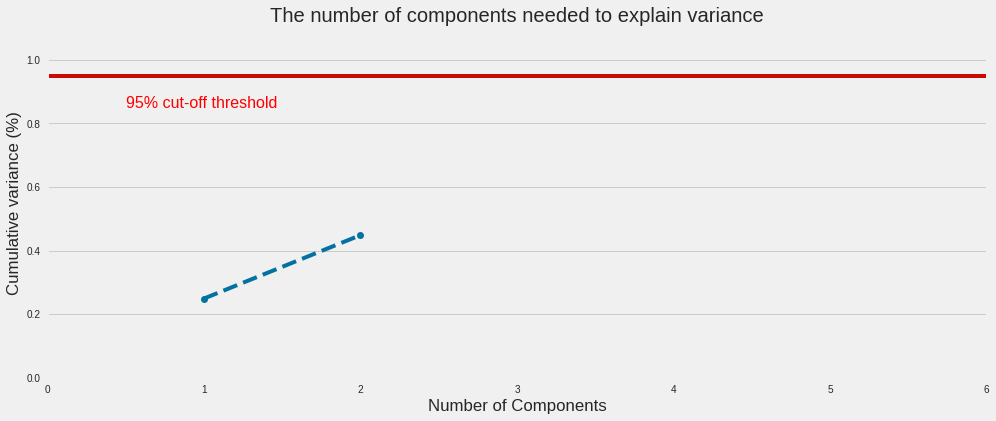

In [156]:
plt.style.use('fivethirtyeight')

plt.rcParams["figure.figsize"] = (15,6)

fig, ax = plt.subplots()
xi = np.arange(1, 3, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 7, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [157]:
# components = pca.components_
# fig, ax = plt.subplots(1,1)
# ax.set_title("PCA")
# ax.scatter(components[0], components[1])

# for i, txt in enumerate(scaled_df.columns.to_list()):
#     ax.annotate(txt, (components[0][i], components[1][i]), xytext=(8,0), textcoords='offset points')

In [158]:
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

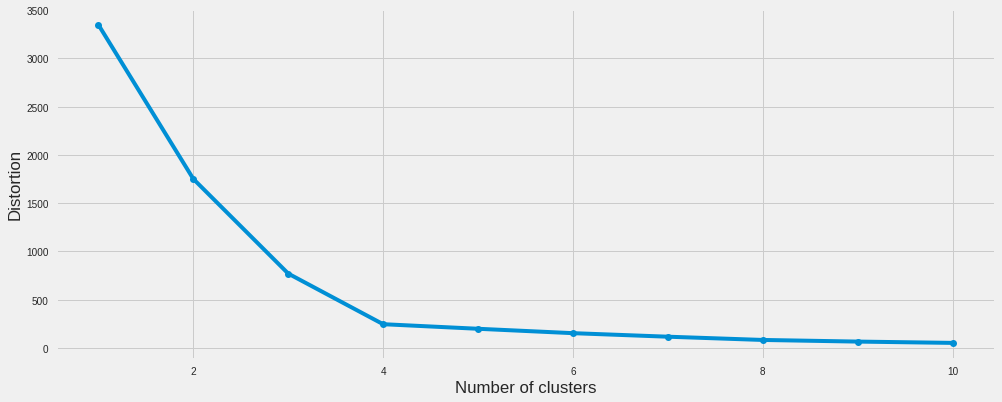

In [159]:
plot_distortion(X_pca)

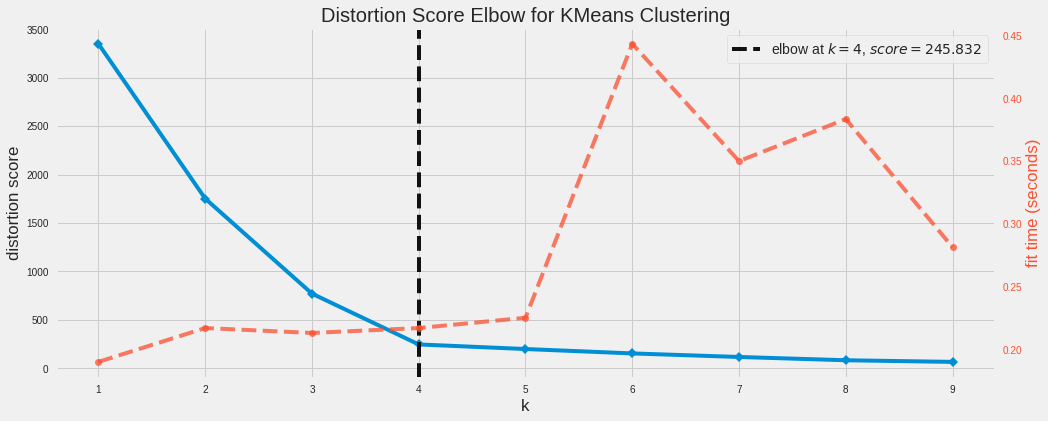

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [160]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(X_pca)
visualizer.poof()

In [161]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_pca)
k_labels = kmeans.labels_

In [173]:
new_columns = kmeans.predict(X_pca)
new_cols = pd.DataFrame(new_columns)
new_cols

,0
0,2
1,2
2,3
3,3
4,1
...,...
742,1
743,2
744,2
745,1


In [163]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster, 0]
        y = X[y_res == cluster, 1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='purple',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

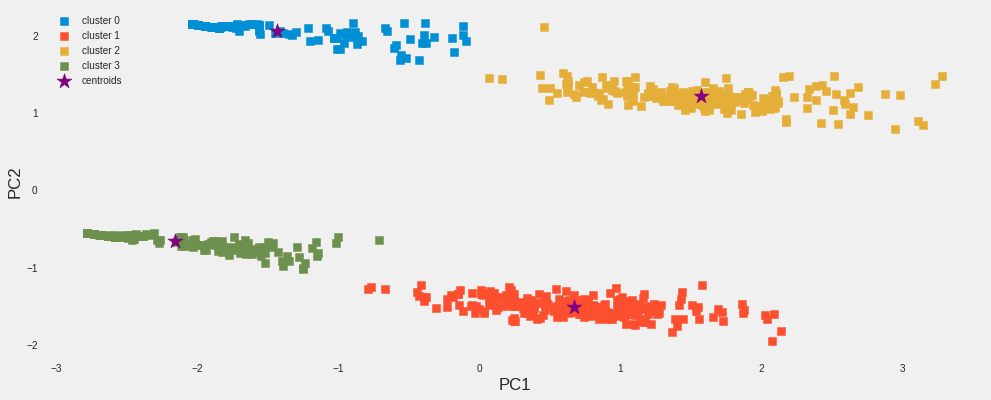

In [168]:
plot_clusters(X_pca, k_labels, plt_cluster_centers= True)

In [170]:
print(k_labels)

[2 2 3 3 1 1 0 1 1 2 3 0 2 3 1 0 2 0 2 0 1 2 1 3 1 1 1 1 1 2 1 2 1 2 3 1 0
 1 0 3 1 1 1 1 3 1 2 1 1 1 0 0 2 2 3 3 2 3 0 2 2 3 0 3 2 3 3 1 3 3 3 1 1 1
 2 1 1 1 3 0 1 1 3 3 1 1 1 1 0 1 1 3 3 3 3 0 3 3 2 2 1 2 1 1 1 2 2 2 2 3 3
 2 2 3 1 1 1 1 2 1 2 2 1 2 0 3 3 1 1 3 2 2 3 1 2 3 0 1 0 0 2 1 1 2 2 3 1 1
 2 1 3 1 1 2 2 1 2 1 2 2 1 2 3 1 2 2 1 2 1 0 1 1 1 2 2 1 1 1 1 2 0 3 3 3 2
 2 1 1 3 1 0 1 0 3 2 3 3 3 1 2 2 1 0 3 2 1 2 1 1 1 0 3 2 0 3 2 0 2 2 1 3 2
 2 2 0 2 0 2 1 1 3 3 0 0 3 0 1 2 3 1 1 0 3 3 0 1 2 3 2 1 2 2 2 2 2 2 1 1 2
 2 2 2 1 1 3 3 1 3 2 1 1 3 3 0 2 1 0 2 1 2 3 2 1 2 1 0 1 1 1 3 3 1 2 3 2 3
 0 1 0 0 3 3 2 3 3 1 1 1 1 2 1 0 0 1 3 2 3 3 2 2 3 2 2 0 1 1 3 2 0 3 2 2 2
 2 0 1 3 2 1 1 0 2 1 3 0 1 1 0 0 1 3 2 2 1 0 3 3 2 1 0 3 2 0 1 3 1 3 1 3 1
 1 1 0 2 3 1 1 2 0 2 1 0 2 3 0 2 1 3 2 2 0 1 1 2 0 3 2 3 2 1 3 1 1 1 1 1 1
 3 0 2 2 1 1 1 2 0 2 3 1 2 0 2 2 1 2 3 2 2 0 3 1 3 2 2 2 0 3 2 0 3 2 1 1 1
 1 0 2 0 1 3 2 2 2 1 1 2 0 1 1 1 2 2 3 3 3 2 0 3 1 3 3 2 2 0 3 3 0 0 0 2 0
 3 1 3 1 2 2 1 1 1 1 3 1 

In [171]:
# use -1 for no savings/credit account

In [172]:
def plot_radar_chart(df):
    data = []
    for i in range(0,len(df)):
        data.append(go.Scatterpolar(r = df.iloc[i].values,
                                    theta = df.iloc[i].index,
                                    name = f'cluster_{df.index[i]}',
                                    fill = 'toself'))
    
    # mean line
    data.append(go.Scatterpolar(r = [100]* df.shape[1],
                                theta= df.columns,
                                name = 'mean',
                                fill = 'toself'))
    
    layout = go.Layout(polar = dict(radialaxis = dict(visible = True)),
                       showlegend = True)
    fig = go.Figure(data = data, layout = layout)
    fig.show()